# Analyses des accidents d'avion (1962-2023)

## Contexte métier

Dans le cadre de sa stratégie de diversification, notre entreprise envisage d’entrer dans le secteur de l’aviation commerciale et privée. Elle souhaite acquérir une flotte d’avions afin de proposer des services de transport aérien. Toutefois, avant de lancer cette nouvelle activité, une étude des risques liés à l’exploitation aérienne est nécessaire.

En particulier, la direction souhaite identifier **les modèles d’avions les plus sûrs**, sur la base d’un historique fiable d’incidents et d’accidents. Nous avons été mandaté pour mener cette analyse en utilisant un ensemble de données fourni par le **National Transportation Safety Board (NTSB)**, couvrant les accidents d’aviation civile entre **1962 et 2023**.

Notre rôle est de :
- Nettoyer et préparer les données ;
- Identifier les types d’aéronefs les plus impliqués dans des accidents ;
- Mettre en évidence les causes récurrentes d’accidents ;
- Visualiser les données de manière claire et interactive ;
- Fournir des **recommandations exploitables** à la division aéronautique pour orienter ses **choix d’acquisition**.

Cette analyse permettra à l’entreprise de limiter les risques humains, financiers et opérationnels associés à cette nouvelle activité, tout en assurant un **niveau de sécurité optimal** pour ses futurs clients.


### Importation des librairies et une petite configuration de base pour l'affichage des graphes

In [370]:
# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

import math

# Configuration de base pour les graphiques
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12,6)

### Chargement des données

In [371]:
df = pd.read_csv('AviationData.csv', encoding='latin1')
df_uss_codes = pd.read_csv('USState_Codes.csv')

C:\Users\macke\AppData\Local\Temp\ipykernel_14792\3613692280.py:1: DtypeWarning: Columns (6,7,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('AviationData.csv', encoding='latin1')


### Fusionner les deux dataframes
Dans ce processus la colonne `Location` du dataframe principale sera spliter pour donner deux nouvelles colonnes `Abbreviation` et `US_State`, de plus pour les location qui se trouvent en dehors des US seront remplies par **Outside US**

In [372]:
# Etape 1 : extraire l'abréviation dpuis la colonne 'Location'
df['State_Abbrev'] = df['Location'].str.extract(r",\s*([A-Z]{2})$")

# Etape 2 : Melanger pour récupérer le nom complet de l'Etat
df = df.merge(df_uss_codes, how='left', left_on='State_Abbrev', right_on='Abbreviation')

# Etape 3 : remplacer les valeurs nulles par "Outside US"
df['US_State'] = df['US_State'].fillna('Outside US')

# Etape 4 : Supprimer la colonne State_Abbrev pour eviter le redondance des données
df = df.drop('State_Abbrev', axis=1)

### Exploration initiale

In [373]:
df.describe(include="all")

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date,US_State,Abbreviation
count,88889,88889,88889,88889,88837,88663,34382,34373,50132,52704,...,77488.000000,76379.000000,76956.000000,82977.000000,84397,61724,82505,75118,88889,82162
unique,87951,2,88863,14782,27758,219,25592,27156,10374,24870,...,NaN,NaN,NaN,NaN,4,12,17074,2924,58,57
top,20001214X45071,Accident,ERA22LA103,2000-07-08,"ANCHORAGE, AK",United States,332739N,0112457W,NONE,Private,...,NaN,NaN,NaN,NaN,VMC,Landing,Probable Cause,25-09-2020,California,CA
freq,3,85015,2,25,434,82248,19,24,1488,240,...,NaN,NaN,NaN,NaN,77303,15428,61754,17019,8857,8857
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.647855,0.279881,0.357061,5.325440,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.485960,1.544084,2.235625,27.913634,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,2.000000,NaN,NaN,NaN,NaN,NaN,NaN


### Netoyage des données

Dans ce processus un nouveau dataframe sera crée appelé `df_clean` qui aura pour but comme sont nom l'indique de contenir les données exploitable pour notre analyse.

Suppression des colonnes `Schedule`, `Air.carrier`, `FAR.Description`, `Aircraft.Category`, `Airport.Code`, `Airport.Name`, `Publication.Date`, `Report.Status`, `Injury.Severity` et `Registration.Number`, car elles contiennent un nombre important de valeurs manquantes et/ou n'apportent pas d'informations pertinentes pour notre analyse.

In [374]:
# Création du dataframe df_clean
df_clean = df.copy()

df_clean.drop(["Schedule", "Air.carrier", "FAR.Description", "Aircraft.Category", "Airport.Code", "Airport.Name", "Publication.Date", "Report.Status", "Registration.Number", "Injury.Severity"], axis=1, inplace=True)

In [375]:
df_clean.head()

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Aircraft.damage,Make,...,Engine.Type,Purpose.of.flight,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,US_State,Abbreviation
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,Destroyed,Stinson,...,Reciprocating,Personal,2.0,0.0,0.0,0.0,UNK,Cruise,Idaho,ID
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,Destroyed,Piper,...,Reciprocating,Personal,4.0,0.0,0.0,0.0,UNK,Unknown,California,CA
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,36.922223,-81.878056,Destroyed,Cessna,...,Reciprocating,Personal,3.0,NaN,NaN,NaN,IMC,Cruise,Virginia,VA
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,NaN,NaN,Destroyed,Rockwell,...,Reciprocating,Personal,2.0,0.0,0.0,0.0,IMC,Cruise,California,CA
4,20041105X01764,Accident,CHI79FA064,1979-08-02,"Canton, OH",United States,NaN,NaN,Destroyed,Cessna,...,NaN,Personal,1.0,2.0,NaN,0.0,VMC,Approach,Ohio,OH


#### Gestion des valeurs manquantes

In [376]:
# Remplisage des valeur manquantes de la colonne "Broad.phase.of.flight" par Unknown, de facon a eviter de perdre des données mais en s'assurant par la d'ignorer les Unknown afin de ne pas forcer les resultats
df_clean['Broad.phase.of.flight'] = df_clean['Broad.phase.of.flight'].fillna('Unknown')

# Remplisage des valeurs manquantes de la colonne "Engine.Type" par Unknown
df_clean['Engine.Type'] = df_clean['Engine.Type'].replace(['LR', 'NONE', 'UNK'], 'Unknown')
df_clean['Engine.Type'] = df_clean['Engine.Type'].fillna('Unknown')

#impoutation des valeurs manquantes de la colonne "Number.of.Engines" par la médiane, étant donné que la distribution est asymétrique
df_clean['Number.of.Engines'] = df_clean['Number.of.Engines'].fillna(df_clean['Number.of.Engines'].median())

# Impoutation des valeurs manquantes des colonnes suivantes par 0 qui est aussi la medianne, cette decision est prise en supposant que les valeurs manquantes de ces colonnes sont du au fait qu'on n'a pas recenccé de tel cas
df_clean[['Total.Minor.Injuries', 'Total.Fatal.Injuries', 'Total.Uninjured', 'Total.Serious.Injuries']] = df_clean[[
    'Total.Minor.Injuries', 'Total.Fatal.Injuries', 'Total.Uninjured', 'Total.Serious.Injuries'
]].fillna(0)

df_clean = df_clean.dropna(subset=['Make', 'Model', 'Amateur.Built'])

df_clean[['Weather.Condition', 'Purpose.of.flight', 'Aircraft.damage']] = df_clean[[
    'Weather.Condition', 'Purpose.of.flight', 'Aircraft.damage'
]].fillna('Unknown')

In [377]:
df_clean.isna().sum()[lambda x: x > 0].sort_values(ascending=False)
df_clean.shape

(88678, 23)

### Analyse des facteurs de risques

**Objectif** : L'objectif ici c'est d'indentifier les types d'avions qui presente le moins de risque.

Ca va passer par 2 etapes principales:
- Une analyse univariée des caracteristiques qui font un avion (`Engine.Type`, `make`, `model`)
- Une analyse par multivarié en croisant les données pour faire un classement global

Ensuite une prochaine etape s'en suivra pour voir si la frequence des accidents des constructeurs analyser a tendance a diminuer avec le temps et de quel type de vol le plus frequent avec les avions gagnant (Personal, Business, etc...)

**Important** : Je ferai le choix d'ignorer pour chacune de ces variables ceux qui ont une frequnce inf a 500 de peur de ne biaiser l'analyse pour manque d'infos leurs concernant 
Par exemples : Pour le moteur electrique on a que 2 blessure fatale mais on a que 10 incidents enregistrer pour lui, ca ne prouve donc pas que c'est plus safe, peut etre que c'est parcqu'il est dans un cadre experimental. Vu l'enjeux vaut mieux ne pas prendre de risque de fausser l'analyse aves des supposition


#### Analyse par type de moteurs

**Objectif** : Déterminer le type de moteur presentant le moins de risque, en determinant `la frequence d'accidents`, `le Taux d'accident mortels` et `Un score de gravité par type de moteur` par types de moteurs

In [378]:
limits = 300

In [379]:
# Fréquence d'accidents par type de moteurs (valeurs absolues)
frequency_engine_type = df_clean[df_clean['Engine.Type'] != 'Unknown']['Engine.Type'].value_counts().sort_values()[lambda x : x > limits]

# Fréquence en pourcentage
percentage_engine_type = frequency_engine_type / frequency_engine_type.sum() * 100

# Affichage combiné
tableau_recapitulatif = pd.DataFrame({
    'Nombre d\'accidents': frequency_engine_type,
    'Pourcentage (%)': percentage_engine_type.round(4)
})

tableau_recapitulatif

,Nombre d'accidents,Pourcentage (%)
Engine.Type,,
Turbo Jet,703,0.8825
Turbo Fan,2472,3.1033
Turbo Prop,3390,4.2558
Turbo Shaft,3607,4.5282
Reciprocating,69484,87.2301


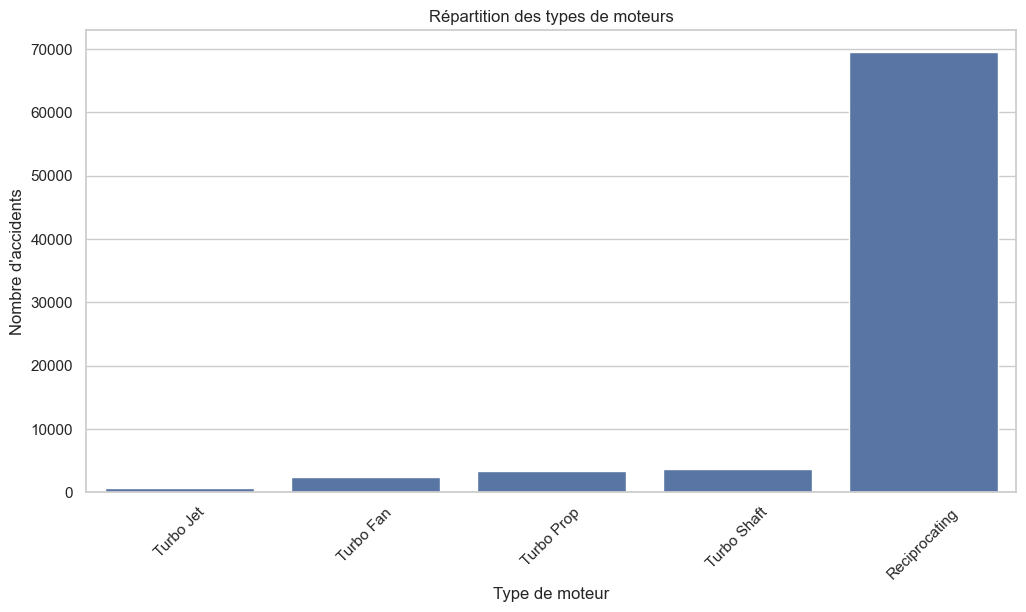

In [380]:
sns.barplot(
    x=tableau_recapitulatif.index,
    y=tableau_recapitulatif["Nombre d'accidents"]
)

plt.title('Répartition des types de moteurs')
plt.xlabel('Type de moteur')
plt.ylabel("Nombre d'accidents")
plt.xticks(rotation=45)
plt.show()

In [381]:
# Calcul du taux d'accidents mortels par type de moteur
mortality_rate_by_engine = df_clean[(df_clean['Engine.Type'] != 'Unknown') & (df_clean['Engine.Type'].isin(frequency_engine_type.index))].groupby('Engine.Type')['Total.Fatal.Injuries'].mean() * 100
mortality_rate_by_engine

Engine.Type
Reciprocating     33.989120
Turbo Fan        184.142395
Turbo Jet        122.617354
Turbo Prop        75.693215
Turbo Shaft       46.964236
Name: Total.Fatal.Injuries, dtype: float64

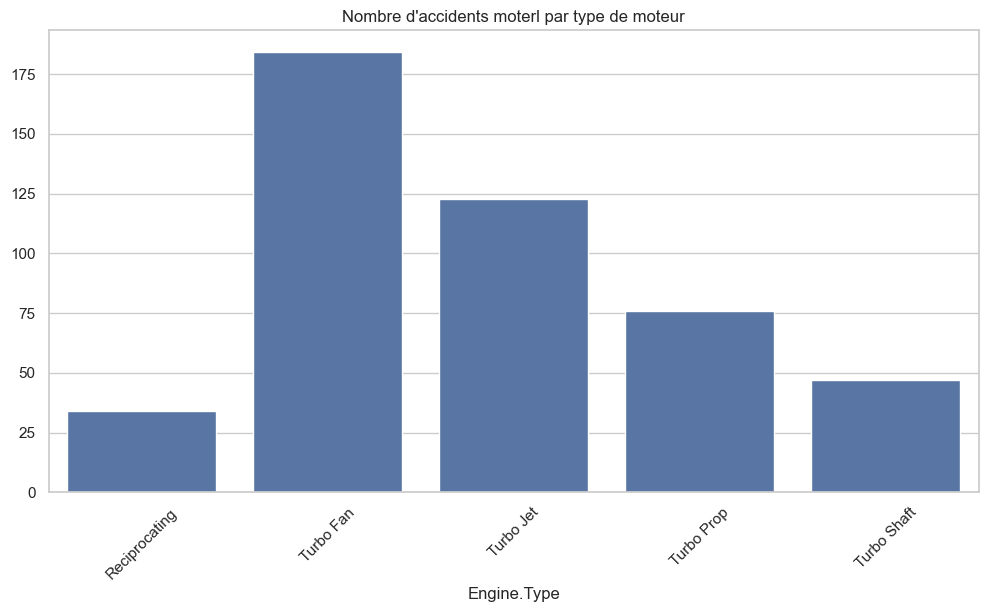

In [382]:
sns.barplot(x=mortality_rate_by_engine.index, y=mortality_rate_by_engine.values)
plt.title('Nombre d\'accidents moterl par type de moteur')
plt.xticks(rotation=45)
plt.show()

In [383]:
# Calcul du score de gravité des accidents par type de moteur

gravity_score_by_engine = df_clean[(df_clean['Engine.Type'] != 'Unknown') & (df_clean['Engine.Type'].isin(frequency_engine_type.index))].groupby('Engine.Type').apply(
    lambda x: (
        (x['Total.Fatal.Injuries'] * 4 + x['Total.Serious.Injuries'] * 2 + x['Total.Minor.Injuries'] * 1).sum() /
        (x['Total.Fatal.Injuries'] + x['Total.Serious.Injuries'] + x['Total.Minor.Injuries']).sum()
        if (x['Total.Fatal.Injuries'] + x['Total.Serious.Injuries'] + x['Total.Minor.Injuries']).sum() > 0
        else 0
    )
)

# Tableau croisé récapitulatif des scores de gravité et des fréquences d'accidents par type de moteur
recap_engine_type = pd.DataFrame({
    'Gravity Score': gravity_score_by_engine,
    'Nombre d\'accidents': frequency_engine_type
})

recap_engine_type.sort_values(by='Gravity Score', ascending=False, inplace=True)
recap_engine_type

C:\Users\macke\AppData\Local\Temp\ipykernel_14792\890166094.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gravity_score_by_engine = df_clean[(df_clean['Engine.Type'] != 'Unknown') & (df_clean['Engine.Type'].isin(frequency_engine_type.index))].groupby('Engine.Type').apply(


,Gravity Score,Nombre d'accidents
Engine.Type,,
Turbo Prop,3.020507,3390
Turbo Jet,2.928913,703
Turbo Fan,2.584466,2472
Reciprocating,2.549870,69484
Turbo Shaft,2.408227,3607


#### Analyse par constructeur (make)

**Objectif** : Voir quels fabricants ont le plus d’incidents et lesquels semblent les plus sûrs, en determinant `la frequence d'accidents`, `le Taux d'accident mortels` et `Un score de gravité par type de moteur` par constructeur

In [384]:
# Normaliser les noms des constructeurs d'avions pour éviter les doublons

df_clean['Make'] = df_clean['Make'].str.title()


In [385]:
# Fréquence d'accidents par constructeur (valeurs absolues)
frequency_make = df_clean[df_clean['Make'] != 'Unknown']['Make'].value_counts().sort_values()[lambda x : x > limits]

# Fréquence en pourcentage
percentage_make = frequency_make / frequency_make.sum() * 100

# Affichage combiné
tableau_recapitulatif_make = pd.DataFrame({
    'Nombre d\'accidents': frequency_make,
    'Pourcentage (%)': percentage_make.round(4)
})

tableau_recapitulatif_make

,Nombre d'accidents,Pourcentage (%)
Make,,
Hiller,348,0.5284
Rockwell,354,0.5375
North American,383,0.5815
Taylorcraft,383,0.5815
Aerospatiale,388,0.5891
Luscombe,414,0.6286
De Havilland,421,0.6392
Aero Commander,429,0.6514
Stinson,439,0.6666


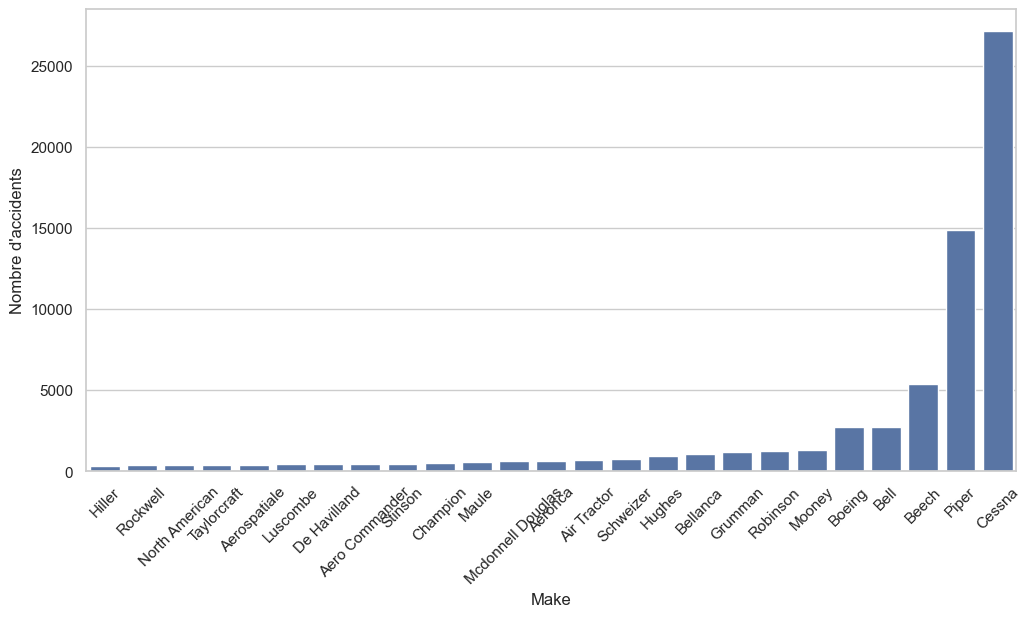

In [386]:
sns.barplot(
    x=tableau_recapitulatif_make.index,
    y=tableau_recapitulatif_make["Nombre d'accidents"]
)

plt.xticks(rotation=45)
plt.show()

In [387]:
# Calcul du taux d'accidents mortels par constructeur
mortality_rate_make = df_clean[(df_clean['Make'] != 'Unknown') & (df_clean['Make'].isin(frequency_make.index))].groupby('Make')['Total.Fatal.Injuries'].mean() * 100
mortality_rate_make.sort_values(inplace=True)
mortality_rate_make

Make
Hiller                 8.620690
Schweizer             11.398964
Stinson               16.173121
Luscombe              17.149758
Air Tractor           17.510854
Aeronca               18.553459
Maule                 18.675722
Taylorcraft           20.365535
Grumman               21.160410
Hughes                21.781116
Champion              26.011561
Bellanca              33.014354
Cessna                35.451764
Piper                 44.865410
Bell                  48.842337
North American        49.869452
Robinson              50.244300
Mooney                51.349325
Rockwell              55.367232
Aero Commander        57.342657
Beech                 70.411776
De Havilland          87.410926
Aerospatiale          89.948454
Mcdonnell Douglas    204.152824
Boeing               315.225425
Name: Total.Fatal.Injuries, dtype: float64

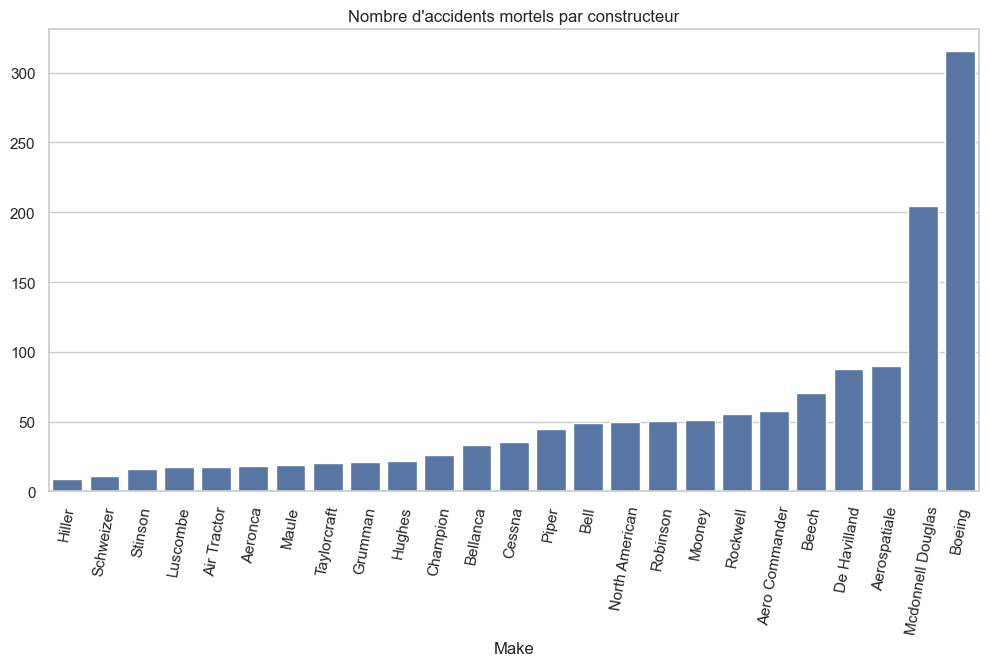

In [388]:
sns.barplot(x=mortality_rate_make.index, y=mortality_rate_make.values)
plt.title('Nombre d\'accidents mortels par constructeur')
plt.xticks(rotation=80)
plt.show()

In [389]:
# Calcul du score de gravité des accidents par type constructeur

gravity_score_by_make = df_clean[(df_clean['Make'] != 'Unknown') & (df_clean['Make'].isin(frequency_make.index))].groupby('Make').apply(
    lambda x: (
        (x['Total.Fatal.Injuries'] * 4 + x['Total.Serious.Injuries'] * 2 + x['Total.Minor.Injuries'] * 1).sum() /
        (x['Total.Fatal.Injuries'] + x['Total.Serious.Injuries'] + x['Total.Minor.Injuries']).sum()
        if (x['Total.Fatal.Injuries'] + x['Total.Serious.Injuries'] + x['Total.Minor.Injuries']).sum() > 0
        else 0
    )
)

# Tableau croisé récapitulatif des scores de gravité et des fréquences d'accidents par type de moteur
recap_make = pd.DataFrame({
    'Gravity Score': gravity_score_by_make,
    'Nombre d\'accidents': frequency_make
})

recap_make.sort_values(by='Gravity Score', ascending=False, inplace=True)
recap_make

C:\Users\macke\AppData\Local\Temp\ipykernel_14792\1734525226.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gravity_score_by_make = df_clean[(df_clean['Make'] != 'Unknown') & (df_clean['Make'].isin(frequency_make.index))].groupby('Make').apply(


,Gravity Score,Nombre d'accidents
Make,,
Boeing,3.063281,2706
Rockwell,3.045455,354
Beech,3.000644,5367
North American,2.993610,383
Aero Commander,2.936768,429
Robinson,2.791342,1228
Mooney,2.739426,1334
De Havilland,2.715054,421
Piper,2.710661,14860


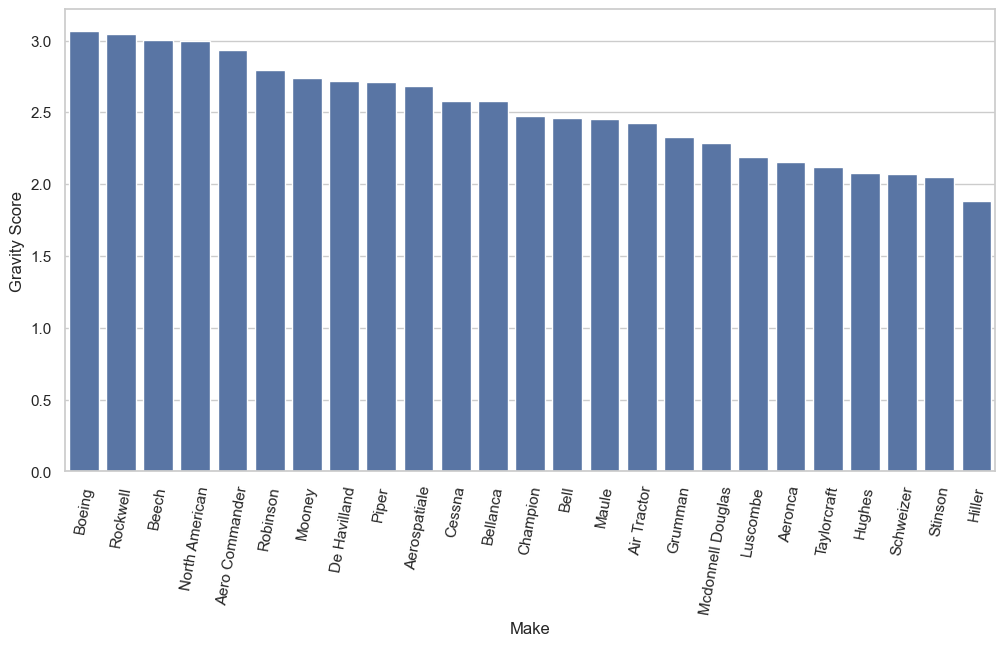

In [390]:
sns.barplot(x=recap_make.index, y=recap_make['Gravity Score'])
plt.xticks(rotation=80)
plt.show()

#### Analyse par model (Model)

**Objectif** : Voir quels model ont le plus d’incidents et lesquels semblent les plus sûrs, en determinant `la frequence d'accidents`, `le Taux d'accident mortels` et `Un score de gravité par type de moteur` par model

In [391]:
# # Fréquence d'accidents par constructeur (valeurs absolues)
frequency_model = df_clean[df_clean['Model'] != 'Unknown']['Model'].value_counts().sort_values()[lambda x : x > limits]

# Fréquence en pourcentage
percentage_model = frequency_model / frequency_model.sum() * 100

# Affichage combiné
tableau_recapitulatif_model = pd.DataFrame({
    'Nombre d\'accidents': frequency_model,
    'Pourcentage (%)': percentage_model.round(4)
})

tableau_recapitulatif_model

,Nombre d'accidents,Pourcentage (%)
Model,,
PA-23-250,311,1.4733
A188B,318,1.5065
PA-12,324,1.5349
PA-28R-200,335,1.5870
269C,341,1.6154
PA-24-250,352,1.6675
182P,356,1.6865
PA-32-300,356,1.6865
R44,361,1.7102


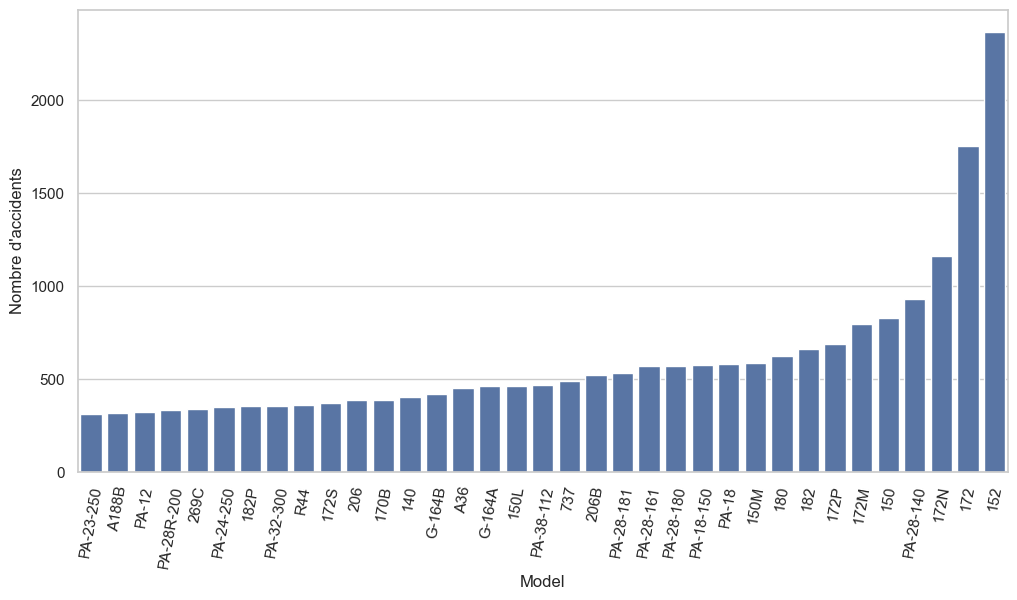

In [392]:
sns.barplot(
    x=tableau_recapitulatif_model.index,
    y=tableau_recapitulatif_model["Nombre d'accidents"]
)

plt.xticks(rotation=80)
plt.show()

In [393]:
# Calcul du taux d'accidents mortels par type de moteur
mortality_rate_model = df_clean[(df_clean['Model'] != 'Unknown') & (df_clean['Model'].isin(frequency_model.index))].groupby('Model')['Total.Fatal.Injuries'].mean().sort_values() * 100
mortality_rate_model

Model
G-164A          4.782609
G-164B          7.142857
140            11.442786
A188B          12.893082
PA-18          15.146299
150            15.319662
170B           15.424165
180            16.559486
152            16.561048
269C           16.715543
150M           17.606838
PA-18-150      18.685121
PA-38-112      20.895522
172S           21.447721
172            22.792023
PA-12          23.148148
150L           27.331887
172M           30.451128
182            33.080425
PA-28-140      34.193548
172P           34.542816
172N           36.941581
182P           38.764045
PA-28-161      39.718805
PA-28-180      46.328671
206B           47.900763
PA-24-250      49.715909
PA-28R-200     57.313433
206            58.868895
PA-32-300      60.955056
PA-28-181      71.616541
A36            76.666667
R44            77.285319
PA-23-250      80.385852
737           276.229508
Name: Total.Fatal.Injuries, dtype: float64

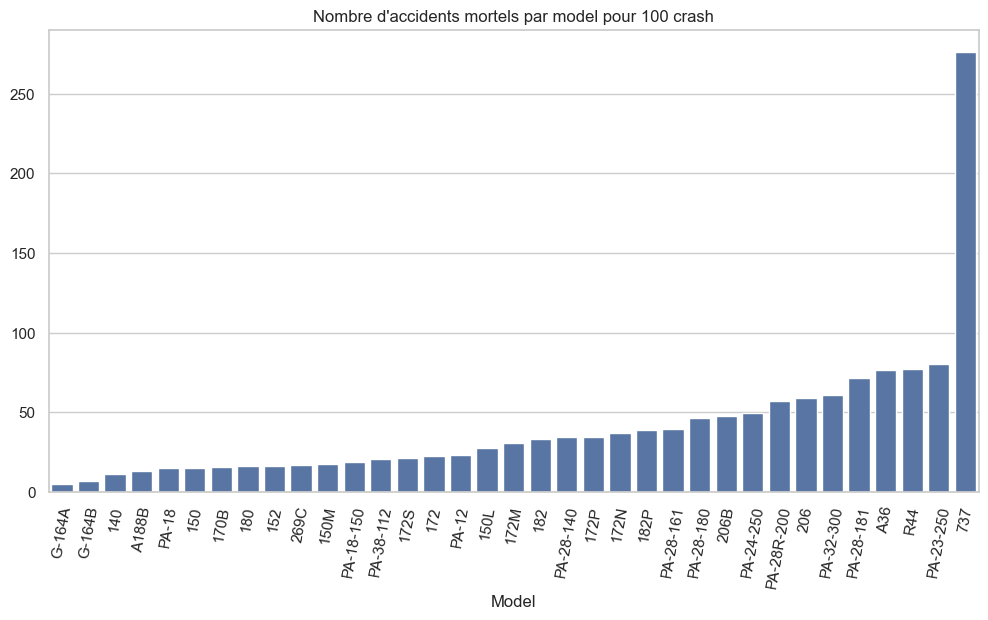

In [394]:
sns.barplot(x=mortality_rate_model.index, y=mortality_rate_model.values)
plt.title('Nombre d\'accidents mortels par model pour 100 crash')
plt.xticks(rotation=80)
plt.show()

In [395]:
# Calcul du score de gravité des accidents par model

gravity_score_by_model = df_clean[(df_clean['Model'] != 'Unknown') & (df_clean['Model'].isin(frequency_model.index))].groupby('Model').apply(
    lambda x: (
        (x['Total.Fatal.Injuries'] * 4 + x['Total.Serious.Injuries'] * 2 + x['Total.Minor.Injuries'] * 1).sum() /
        (x['Total.Fatal.Injuries'] + x['Total.Serious.Injuries'] + x['Total.Minor.Injuries']).sum()
        if (x['Total.Fatal.Injuries'] + x['Total.Serious.Injuries'] + x['Total.Minor.Injuries']).sum() > 0
        else 0
    )
)

# Tableau croisé récapitulatif des scores de gravité et des fréquences d'accidents par type de moteur
recap_model = pd.DataFrame({
    'Gravity Score': gravity_score_by_model,
    'Nombre d\'accidents': frequency_model
})

recap_model.sort_values(by='Gravity Score', ascending=False, inplace=True)
recap_model

C:\Users\macke\AppData\Local\Temp\ipykernel_14792\3788528878.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gravity_score_by_model = df_clean[(df_clean['Model'] != 'Unknown') & (df_clean['Model'].isin(frequency_model.index))].groupby('Model').apply(


,Gravity Score,Nombre d'accidents
Model,,
737,3.425835,488
PA-23-250,3.046392,311
A36,2.972696,450
R44,2.944444,361
PA-28R-200,2.897059,335
PA-28-181,2.853767,532
206,2.792148,389
172S,2.740741,373
PA-24-250,2.703081,352


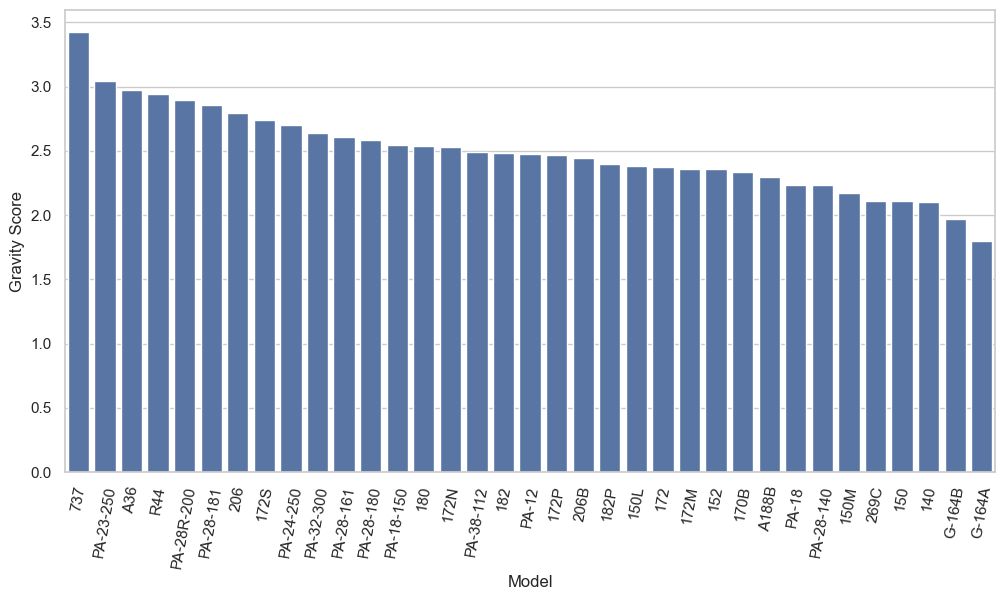

In [396]:
sns.barplot(x=recap_model.index, y=recap_model['Gravity Score'])
plt.xticks(rotation=80)
plt.show()